# Analysis of Various Machine Learning Models

The point of this notebook is to analyize the benefits and learning capabilities of various ML models. The models tested here include:
1. Regression Random Forest
2. SVR
3. Fully Connected Feed Forward Neural Network
4. Convolutional Neural Network
5. Recurrent Neural Network (LSTM)

[6.0472865  7.80185479 4.57663845 ... 4.46607541 5.27923593 5.92581478]


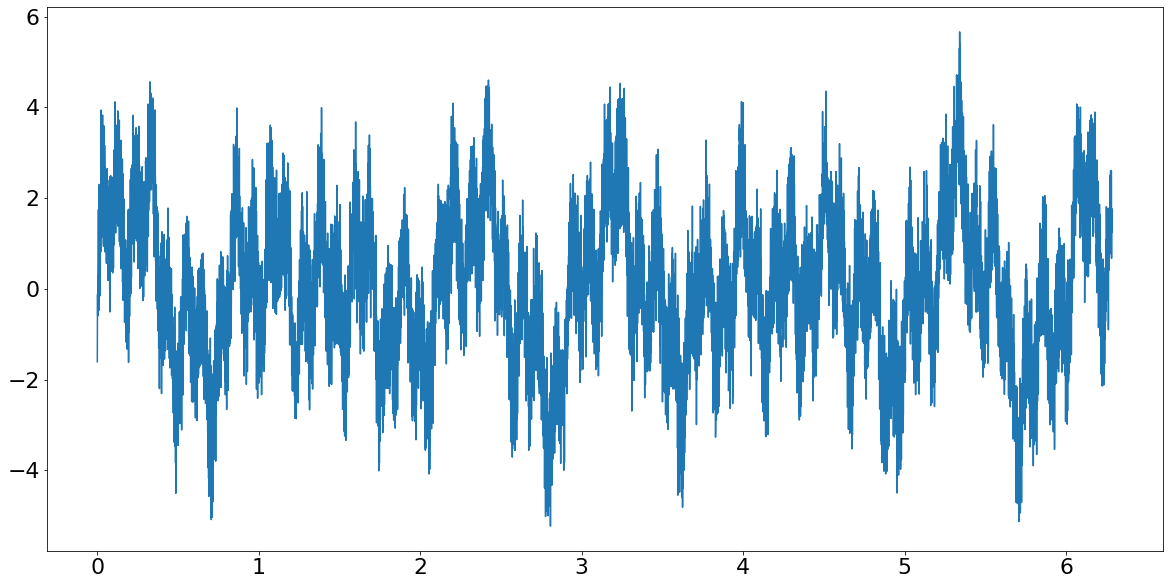

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


rng = np.random.default_rng(1)
x = np.linspace(0, 2*np.pi, 10000)
noise = 0.8

y_theta = np.sin((rng.normal(loc=6, scale=1))*x) + rng.uniform(-noise, noise, size=x.size)
y_alpha = np.sin((rng.normal(loc=10, scale=1))*x) + rng.uniform(-noise, noise, size=x.size)
y_beta = np.sin((rng.normal(loc=23, scale=1)) * x) + rng.uniform(-noise, noise, size=x.size)
y_gamma = np.sin((rng.normal(loc=60, scale=1))*x)

y = y_theta + y_alpha + y_beta + y_gamma
df = pd.DataFrame(dict({'input': y, 'output': y_gamma}))

plt.plot(x, y)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

temp_df = df.copy(deep=True)

predict_ahead = 50

X = temp_df['output'].to_numpy()
Y = np.roll((temp_df['output'].to_numpy()), predict_ahead)

X_train = []
Y_train = []
X_test = []
Y_test = []
rng = np.random.default_rng(1)
idx = rng.choice(650, 500)
for id in idx:
    X_train.append(X[id:id+100])
    Y_train.append(Y[id:id+predict_ahead])

idx = rng.choice(np.arange(750, 900), 250)
for id in idx:
    X_test.append(X[id:id+100])
    Y_test.append(Y[id:id+predict_ahead])

X_train = np.stack(X_train)
Y_train = np.stack(Y_train)
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)
print(X_train.shape)

(500, 100)


Training R^2: 0.9440
Testing R^2: 0.9308


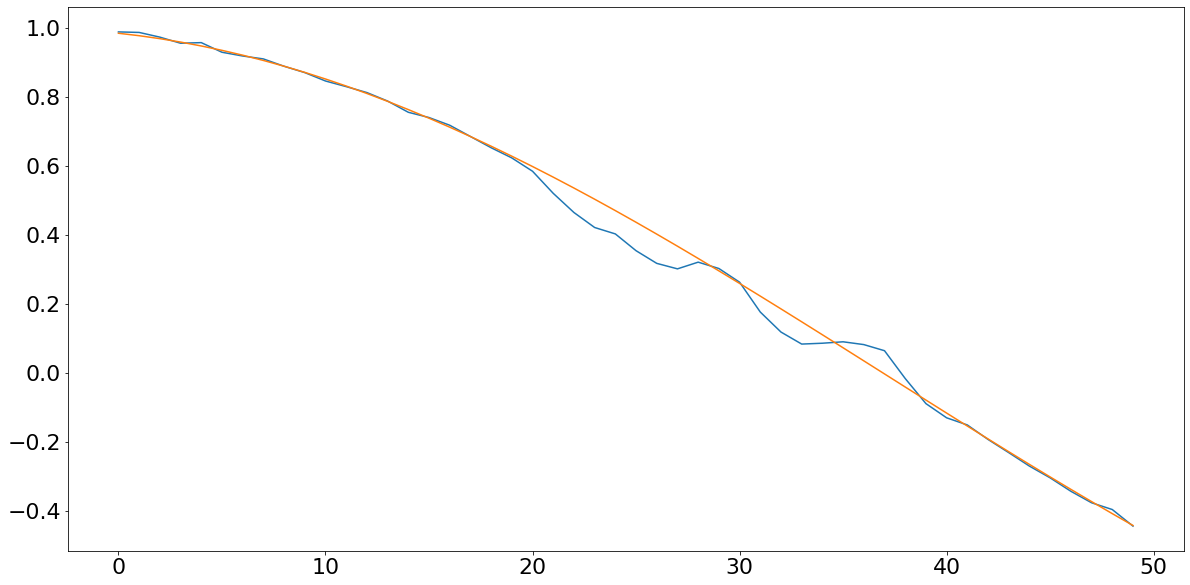

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

clf = MultiOutputRegressor(RandomForestRegressor(max_depth=5)).fit(X_train, Y_train)
print('Training R^2: {:.4f}'.format(clf.score(X_train, Y_train)))
print('Testing R^2: {:.4f}'.format(clf.score(X_test, Y_test)))


predi = clf.predict(X_test[0,:].reshape(1, -1))
label = Y_test[0,:]
plt.plot(np.arange(predict_ahead), np.squeeze(predi))
plt.plot(np.arange(predict_ahead), np.squeeze(label))
plt.show()

Training R^2: 0.8618
Testing R^2: 0.9848


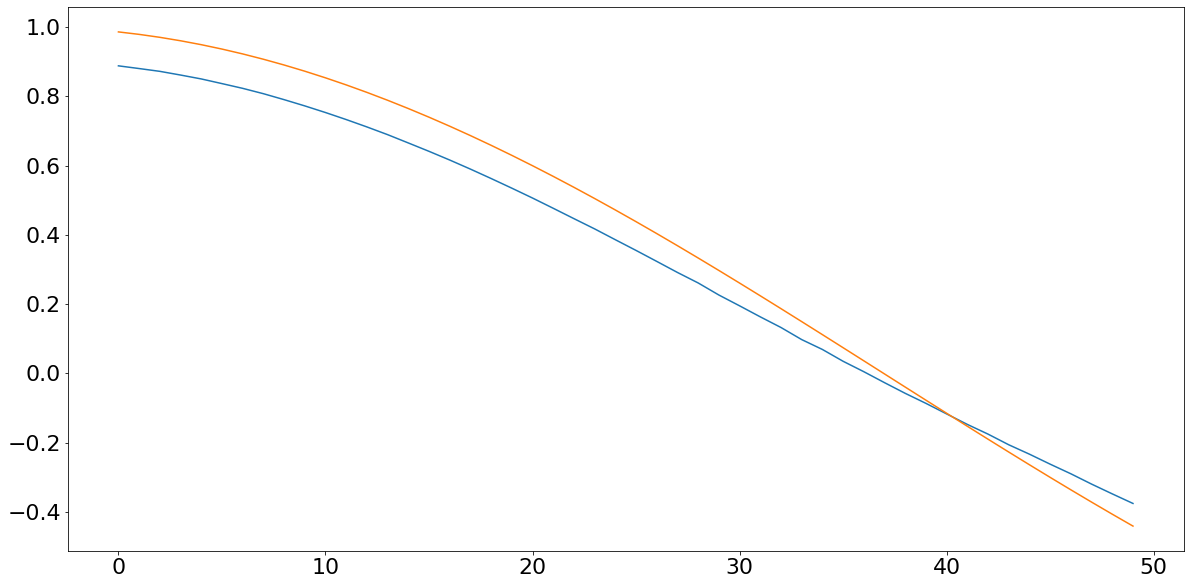

In [12]:
from sklearn.svm import SVR

clf = MultiOutputRegressor(SVR(kernel='rbf')).fit(X_train, Y_train)
print('Training R^2: {:.4f}'.format(clf.score(X_train, Y_train)))
print('Testing R^2: {:.4f}'.format(clf.score(X_test, Y_test)))


predi = clf.predict(X_test[0,:].reshape(1, -1))
label = Y_test[0,:]
plt.plot(np.arange(predict_ahead), np.squeeze(predi))
plt.plot(np.arange(predict_ahead), np.squeeze(label))
plt.show()

Training R^2: 0.8888
Testing R^2: 0.9730


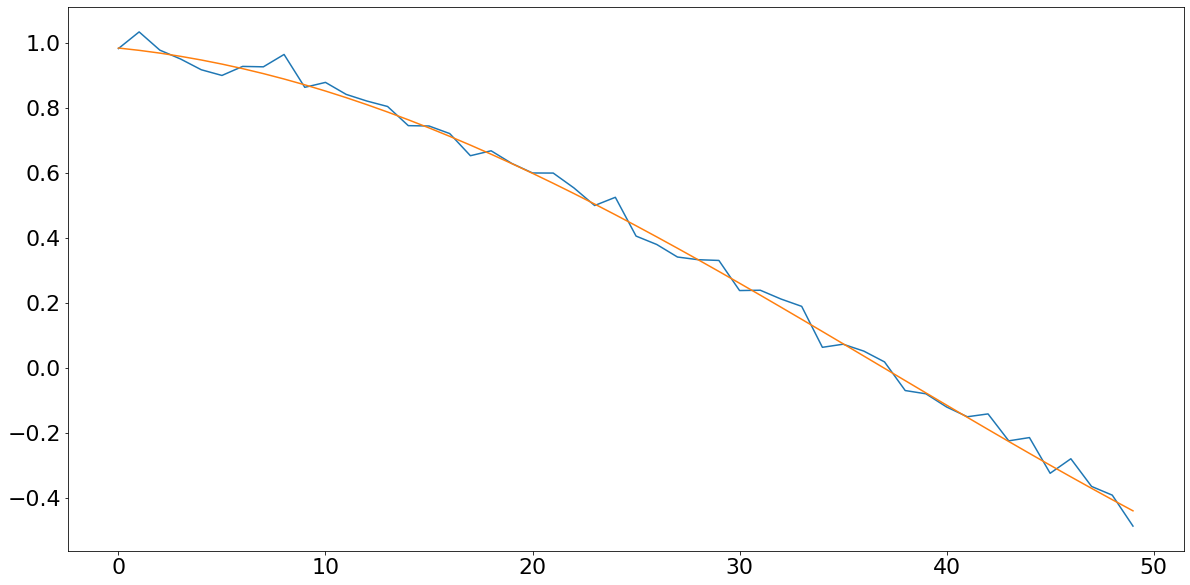

In [13]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(150,10), max_iter=500).fit(X_train, Y_train)
print('Training R^2: {:.4f}'.format(clf.score(X_train, Y_train)))
print('Testing R^2: {:.4f}'.format(clf.score(X_test, Y_test)))


predi = clf.predict(X_test[0,:].reshape(1, -1))
label = Y_test[0,:]
plt.plot(np.arange(predict_ahead), np.squeeze(predi))
plt.plot(np.arange(predict_ahead), np.squeeze(label))
plt.show()

In [14]:
import torch.nn as nn
from tqdm.notebook import tqdm
import torch
from torch.fft import rfft
from scipy import stats
from typing import Tuple, List, Optional

def train_model(model: nn.Module,
                training_loader: torch.utils.data.DataLoader,
                validation_loader: torch.utils.data.DataLoader,
                epochs: int,
                device: torch.device) -> Tuple[List[float], List[float]]:
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)  #1e-5)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)
    loss_func = nn.MSELoss()
    decay_rate = .98 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    validation_loss, training_loss = [], []

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)

                loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
                training_loss.append(train_loss)
            else:
                val_loss = running_loss
                validation_loss.append(val_loss)

        # shows total loss
        if epoch%5 == 0:
            # if True:
            tqdm.write('[%d] train loss: %.6f val loss: %.6f' % (epoch + 1, train_loss, val_loss))
    return training_loss, validation_loss

In [15]:
import copy
from lfp_prediction.models.LFPNet import FCN, CNN, BaselineLSTM
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

print(np.expand_dims(X_test, axis=1).shape)

train_data = DataLoader(TensorDataset(torch.Tensor(np.expand_dims(X_train, axis=1)),
                                      torch.Tensor(np.expand_dims(Y_train, axis=1))),
                        batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(np.expand_dims(X_test, axis=1)),
                                      torch.Tensor(np.expand_dims(Y_test, axis=1))),
                        batch_size=batch_size, shuffle=False)

epochs = 50

# model = CNN(in_size=2048, h_size=500, out_size=10)
# model = FCN(in_size=2048, h_size=500, out_size=10)
model = BaselineLSTM(in_size=1, h_size=50, out_size=50)
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = train_model(model, train_data, valid_data, epochs, device)

(250, 1, 100)


  0%|          | 0/50 [00:00<?, ?it/s]

[1] train loss: 8.219906 val loss: 3.868297
[6] train loss: 2.695301 val loss: 0.945475
[11] train loss: 1.253516 val loss: 0.225541
[16] train loss: 0.969550 val loss: 0.102891
[21] train loss: 1.007760 val loss: 0.107722
[26] train loss: 0.983092 val loss: 0.104119
[31] train loss: 0.950350 val loss: 0.080771
[36] train loss: 0.962973 val loss: 0.133995
[41] train loss: 0.955490 val loss: 0.099448
[46] train loss: 0.931357 val loss: 0.080694


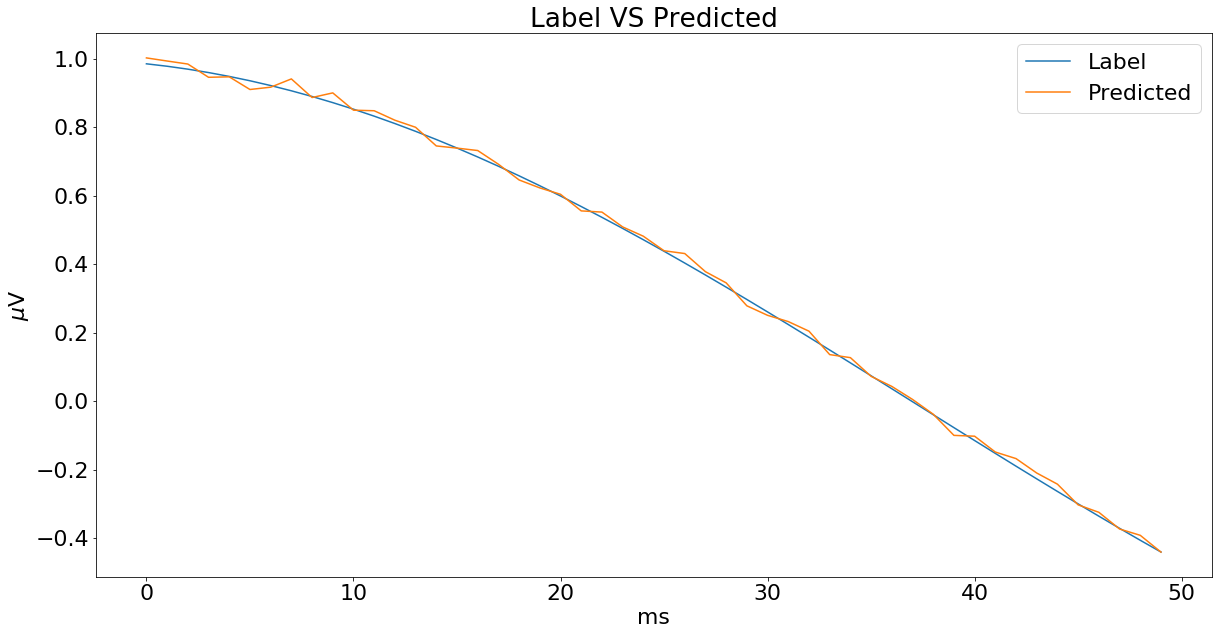

In [16]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

%matplotlib inline
from matplotlib.ticker import FormatStrFormatter


plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

plt.figure(figsize=(20,10))
plt.plot(np.arange(predict_ahead), y[0,0,:], label='Label')
plt.plot(np.arange(predict_ahead), output[0,:], label='Predicted')
plt.xlabel('ms')
plt.ylabel(r'$\mu$V')
plt.title('Label VS Predicted')
plt.legend(loc='best')
plt.show()